# Training models with FordA dataset


- pre processing the dataset
    - load train data file and test data file(modified by FordA_visualization.ipynb)
    - split train data and validation data (80: 20)
    - normalize the data, reshape the data

- train models and store the best model
    - CNN
    - RNN
    - LSTM
    - GRU

In [106]:
from google.colab import drive
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import keras
import matplotlib.pyplot as plt
import statistics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold


## Load data file
- mount to Google drive
- load modified data from the drive

In [107]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [108]:
cd /content/drive/My\ Drive/Colab\ Notebooks/summer_coop/FordA

/content/drive/My Drive/Colab Notebooks/summer_coop/FordA


In [109]:
ls

ai4i2020_result.png                       FordA_result.tsv
best_cnn_model.h5                         FordA_test_modified.npy
best_gru_model.h5                         FordA_TEST.tsv
best_lstm_model.h5                        FordA_TRAIN.tsv
best_rnn_model.h5                         FordA_visualization.ipynb
cnn_architecture.png                      gru_architecture.png
FordA_Correlation_bw_failure_sensors.png  lstm_architecture.png
FordA_modified.npy                        rnn_architecture.png
FordA_result.gsheet                       rnn-architecture.png
FordA_result.png                          xgboost_result.png


In [110]:
data_arr = np.load('./FordA_modified.npy')
data_arr[:10, 0]

array([1., 0., 1., 1., 1., 0., 0., 0., 0., 0.])

### split features and class
- feuture: 500 sensors' value (col 1 ~ 500)
- class: machine failure (col 0)
    - 0: normal situation
    - 1: failure situation

In [111]:
train_target = data_arr[:, 0]
train_input = data_arr[:, 1:]
print(train_target.shape, train_input.shape)

(3601,) (3601, 500)


## Normalize the data

In [112]:
mean = train_input.mean()
std = train_input.std()
train_scaled = (train_input - mean) / std

## Reshape the data
- keras CNN, RNN needs 3 dim inputs
    - (3601, 500) -> (3601, 500, 1)

In [113]:
train_scaled = train_scaled.reshape(-1, 500, 1)

## Split train data and validation data
- train: validation = 80: 20

In [114]:

train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target, stratify = train_target, test_size = 0.2)
print(train_scaled.shape, val_scaled.shape, train_target.shape, val_target.shape)

(2880, 500, 1) (721, 500, 1) (2880,) (721,)


## Training model
- binary classification
- supervised training

### CNN

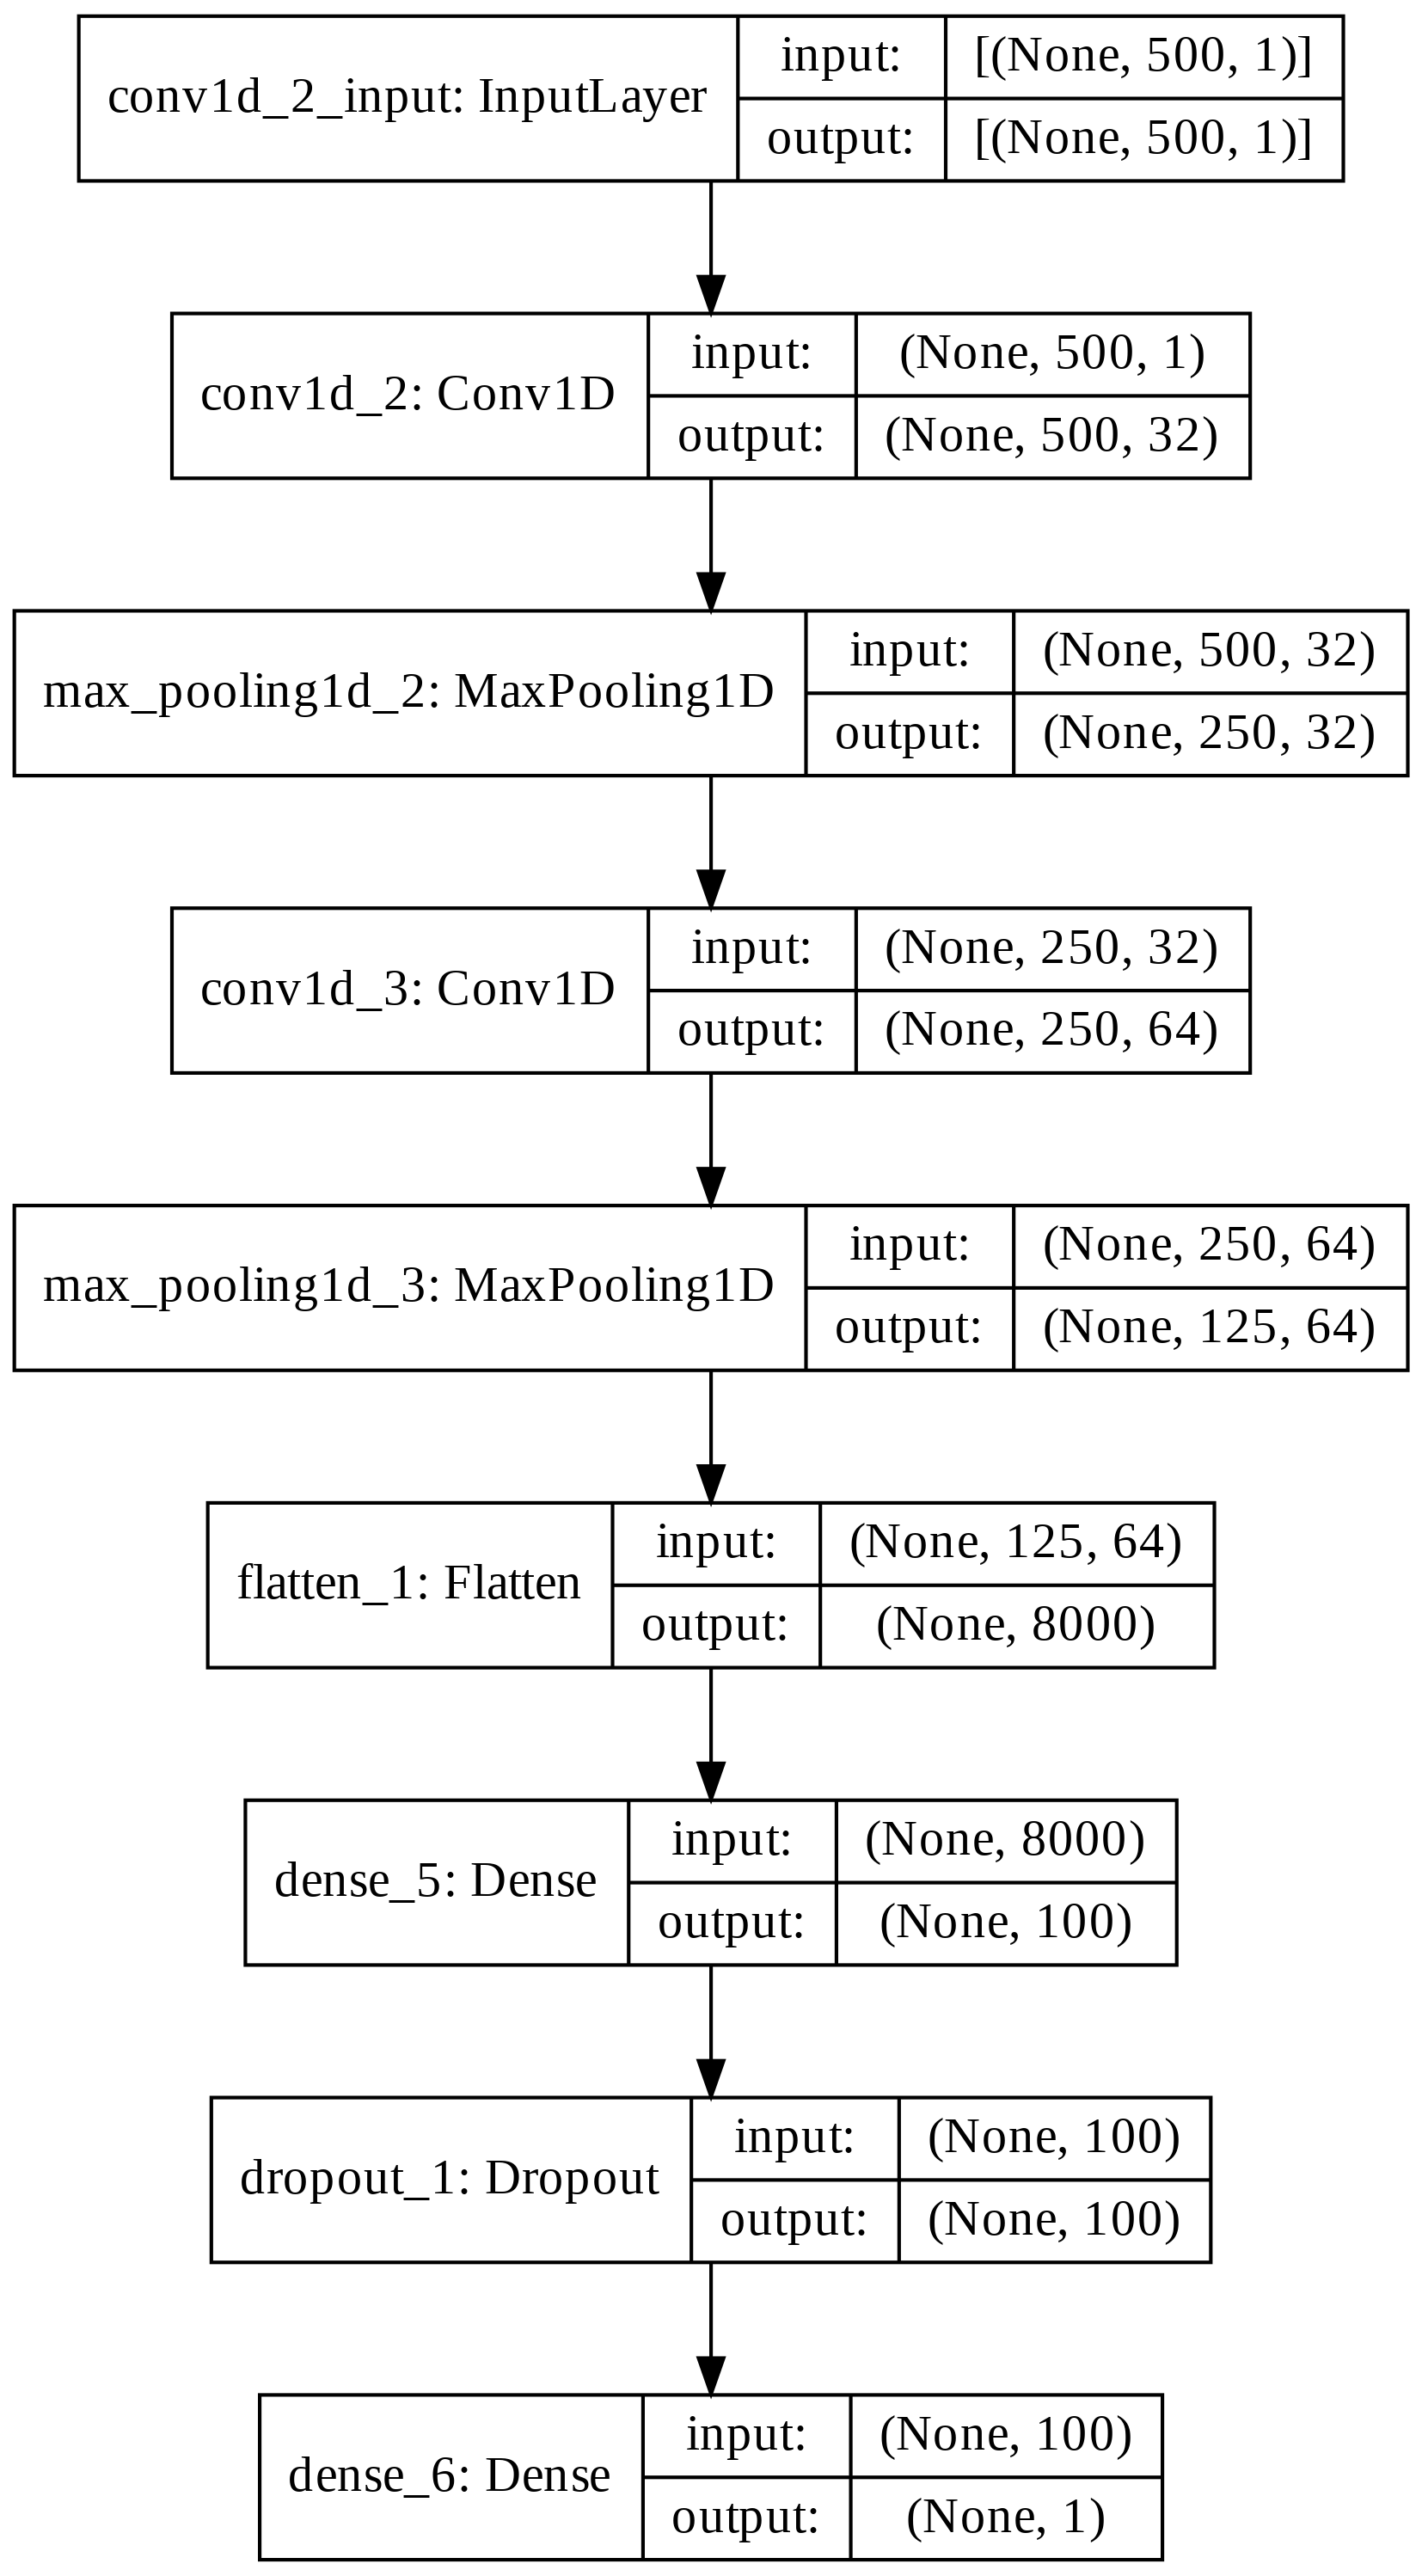

In [115]:
cnn = keras.Sequential()
cnn.add(keras.layers.Conv1D(32, kernel_size=2, padding = 'same', activation = 'relu', input_shape = (500, 1)))
cnn.add(keras.layers.MaxPooling1D(2))
cnn.add(keras.layers.Conv1D(64, kernel_size=2, padding = 'same', activation = 'relu'))
cnn.add(keras.layers.MaxPooling1D(2))
cnn.add(keras.layers.Flatten())
cnn.add(keras.layers.Dense(100, activation = 'relu'))
cnn.add(keras.layers.Dropout(0.4))
cnn.add(keras.layers.Dense(1, activation = 'sigmoid'))
keras.utils.plot_model(cnn, to_file = './cnn_architecture.png', show_shapes = True, dpi = 300)


In [116]:
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = 'accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint('./best_cnn_model.h5')
earlystopping_cb = keras.callbacks.EarlyStopping(patience = 3, restore_best_weights=True)
cnn_history = cnn.fit(train_scaled, train_target, epochs = 100, validation_data = (val_scaled, val_target), callbacks = [checkpoint_cb, earlystopping_cb])

Epoch 1/100
90/90 [==============================] - 3s 32ms/step - loss: 0.6955 - accuracy: 0.5441 - val_loss: 0.6693 - val_accuracy: 0.6671
Epoch 2/100
90/90 [==============================] - 3s 31ms/step - loss: 0.6172 - accuracy: 0.6656 - val_loss: 0.5729 - val_accuracy: 0.7476
Epoch 3/100
90/90 [==============================] - 3s 31ms/step - loss: 0.5341 - accuracy: 0.7410 - val_loss: 0.5343 - val_accuracy: 0.7060
Epoch 4/100
90/90 [==============================] - 3s 31ms/step - loss: 0.4669 - accuracy: 0.7795 - val_loss: 0.4678 - val_accuracy: 0.7767
Epoch 5/100
90/90 [==============================] - 3s 31ms/step - loss: 0.4229 - accuracy: 0.8035 - val_loss: 0.4305 - val_accuracy: 0.7920
Epoch 6/100
90/90 [==============================] - 3s 31ms/step - loss: 0.3870 - accuracy: 0.8201 - val_loss: 0.4045 - val_accuracy: 0.7864
Epoch 7/100
90/90 [==============================] - 3s 31ms/step - loss: 0.3508 - accuracy: 0.8420 - val_loss: 0.3781 - val_accuracy: 0.8350
Epoch 

### RNN

In [117]:
rnn = keras.Sequential()
rnn.add(keras.layers.SimpleRNN(10, input_shape = (500,1)))
rnn.add(keras.layers.Dense(1, activation = 'sigmoid'))
keras.utils.plot_model(rnn, show_shapes = True, dpi = 300, to_file = './rnn_architecture.png')
rms = keras.optimizers.RMSprop(learning_rate = 1e-4)


In [118]:
rnn.compile(optimizer = rms, loss = 'binary_crossentropy', metrics = ['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('./best_rnn_model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 3, restore_best_weights = True)
rnn_history = rnn.fit(train_scaled, train_target, epochs = 100, validation_data = (val_scaled, val_target), callbacks = [checkpoint_cb, early_stopping_cb])

Epoch 1/100
90/90 [==============================] - 6s 63ms/step - loss: 0.7167 - accuracy: 0.4865 - val_loss: 0.7033 - val_accuracy: 0.4951
Epoch 2/100
90/90 [==============================] - 6s 61ms/step - loss: 0.7098 - accuracy: 0.4809 - val_loss: 0.6993 - val_accuracy: 0.5007
Epoch 3/100
90/90 [==============================] - 5s 60ms/step - loss: 0.7050 - accuracy: 0.4799 - val_loss: 0.6970 - val_accuracy: 0.4979
Epoch 4/100
90/90 [==============================] - 5s 60ms/step - loss: 0.7019 - accuracy: 0.4771 - val_loss: 0.6956 - val_accuracy: 0.4993
Epoch 5/100
90/90 [==============================] - 5s 60ms/step - loss: 0.6997 - accuracy: 0.4795 - val_loss: 0.6949 - val_accuracy: 0.4924
Epoch 6/100
90/90 [==============================] - 6s 61ms/step - loss: 0.6984 - accuracy: 0.4809 - val_loss: 0.6946 - val_accuracy: 0.4813
Epoch 7/100
90/90 [==============================] - 5s 59ms/step - loss: 0.6974 - accuracy: 0.4858 - val_loss: 0.6944 - val_accuracy: 0.4965
Epoch 

### LSTM

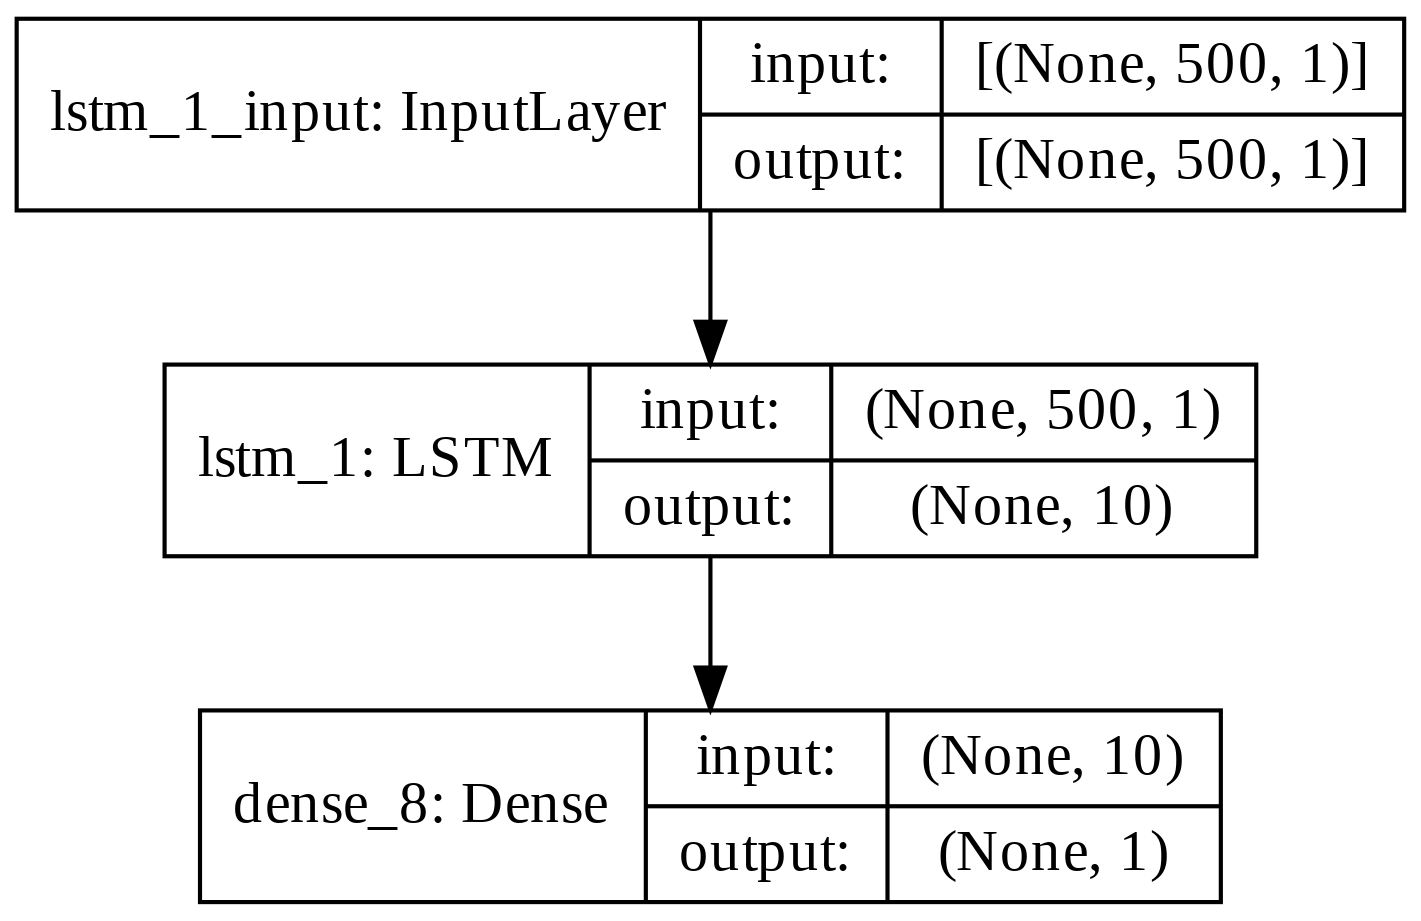

In [119]:
lstm = keras.Sequential()
lstm.add(keras.layers.LSTM(10, input_shape=(500, 1)))
lstm.add(keras.layers.Dense(1, activation = 'sigmoid'))
keras.utils.plot_model(lstm, to_file = './lstm_architecture.png', show_shapes = True, dpi = 300)

In [120]:
rms = keras.optimizers.RMSprop(learning_rate = 1e-4)
checkpoint_cb = keras.callbacks.ModelCheckpoint('./best_lstm_model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience= 3, restore_best_weights= True)
lstm.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
lstm_history = lstm.fit(train_scaled, train_target, epochs = 100, validation_data = (val_scaled, val_target), callbacks = [checkpoint_cb, early_stopping_cb])

Epoch 1/100
90/90 [==============================] - 11s 100ms/step - loss: 0.6938 - accuracy: 0.5010 - val_loss: 0.6934 - val_accuracy: 0.5215
Epoch 2/100
90/90 [==============================] - 8s 93ms/step - loss: 0.6931 - accuracy: 0.5208 - val_loss: 0.6931 - val_accuracy: 0.5146
Epoch 3/100
90/90 [==============================] - 8s 92ms/step - loss: 0.6929 - accuracy: 0.5122 - val_loss: 0.6927 - val_accuracy: 0.5173
Epoch 4/100
90/90 [==============================] - 8s 93ms/step - loss: 0.6929 - accuracy: 0.5146 - val_loss: 0.6925 - val_accuracy: 0.5146
Epoch 5/100
90/90 [==============================] - 8s 93ms/step - loss: 0.6926 - accuracy: 0.5247 - val_loss: 0.6921 - val_accuracy: 0.5132
Epoch 6/100
90/90 [==============================] - 8s 91ms/step - loss: 0.6924 - accuracy: 0.5139 - val_loss: 0.6919 - val_accuracy: 0.5049
Epoch 7/100
90/90 [==============================] - 9s 95ms/step - loss: 0.6922 - accuracy: 0.5156 - val_loss: 0.6918 - val_accuracy: 0.5340
Epoc

### GRU

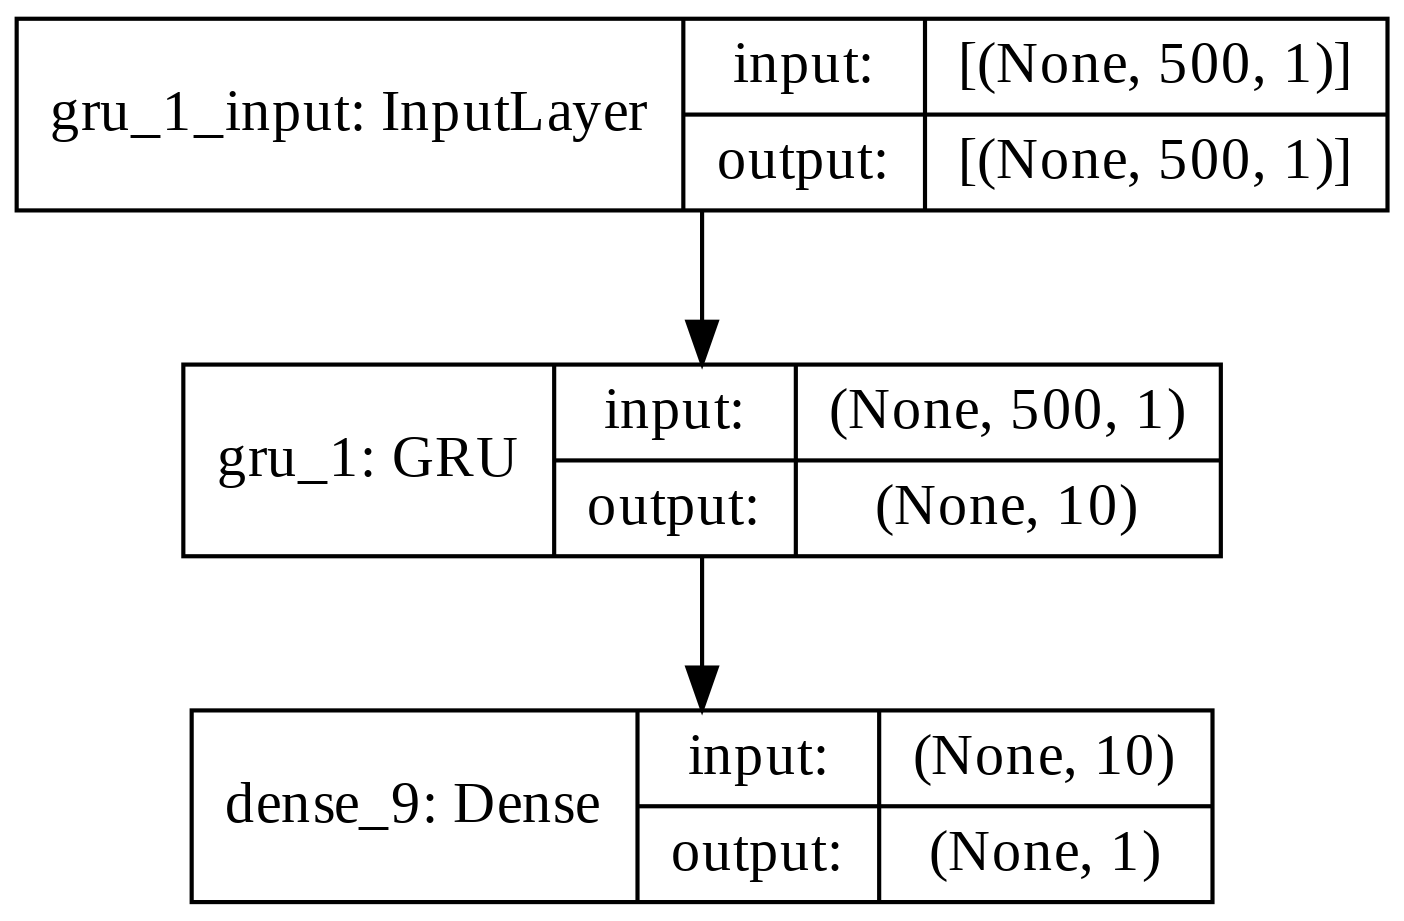

In [121]:
gru = keras.Sequential()
gru.add(keras.layers.GRU(10, input_shape = (500, 1)))
gru.add(keras.layers.Dense(1, activation = 'sigmoid'))
keras.utils.plot_model(gru, to_file = './gru_architecture.png', show_shapes = True, dpi = 300)

In [122]:
rms = keras.optimizers.RMSprop(learning_rate=1e-4)
gru.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('./best_gru_model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
gru_history = gru.fit(train_scaled, train_target, epochs = 100, validation_data = (val_scaled, val_target), callbacks = [checkpoint_cb, early_stopping_cb])

Epoch 1/100
90/90 [==============================] - 10s 95ms/step - loss: 0.6940 - accuracy: 0.5063 - val_loss: 0.6943 - val_accuracy: 0.5229
Epoch 2/100
90/90 [==============================] - 8s 92ms/step - loss: 0.6934 - accuracy: 0.5063 - val_loss: 0.6932 - val_accuracy: 0.5270
Epoch 3/100
90/90 [==============================] - 8s 90ms/step - loss: 0.6935 - accuracy: 0.5063 - val_loss: 0.6930 - val_accuracy: 0.5284
Epoch 4/100
90/90 [==============================] - 8s 91ms/step - loss: 0.6928 - accuracy: 0.5049 - val_loss: 0.6926 - val_accuracy: 0.5298
Epoch 5/100
90/90 [==============================] - 8s 90ms/step - loss: 0.6929 - accuracy: 0.5128 - val_loss: 0.6923 - val_accuracy: 0.5201
Epoch 6/100
90/90 [==============================] - 8s 92ms/step - loss: 0.6926 - accuracy: 0.5170 - val_loss: 0.6922 - val_accuracy: 0.5201
Epoch 7/100
90/90 [==============================] - 8s 92ms/step - loss: 0.6926 - accuracy: 0.5198 - val_loss: 0.6918 - val_accuracy: 0.5229
Epoch

## Data preprocessing for machine learning

In [123]:
data_input = data_arr[:, 1:]
data_target = data_arr[:, 0] 
print(data_input.shape, data_target.shape)

(3601, 500) (3601,)


In [124]:
train_input, test_input, train_target, test_target = train_test_split(data_input, data_target, test_size = 0.2, stratify = data_target)

In [125]:
print(train_input.shape, test_input.shape)

(2880, 500) (721, 500)


### Normalization
- normalize with train data's mean and std

In [126]:
ss = StandardScaler()
ss.fit(train_input)
train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

In [127]:
print(train_scaled.shape, test_scaled.shape)

(2880, 500) (721, 500)


### Logistic Regressioin

In [129]:
lr = LogisticRegression(max_iter = 2000)
splitter = StratifiedKFold(n_splits = 10)
lr_score = cross_validate(lr, train_scaled, train_target, cv = splitter, return_train_score= True, return_estimator= True)

In [130]:
print(np.mean(lr_score['train_score']), np.mean(lr_score['test_score']))

0.5957175925925926 0.4989583333333333


In [131]:
print(lr_score['estimator'])
print(lr_score['train_score'])

(LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=2000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False), LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=2000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False), LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=2000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False), LogisticRegress

In [132]:
lr = LogisticRegression(max_iter = 2000)
lr.fit(train_scaled, train_target)
print(lr.score(train_scaled, train_target), lr.score(test_scaled, test_target))

0.5951388888888889 0.4895977808599168


### XGBoost
- find the best max_depth (range: 1 ~ 20)

In [29]:
train_scores = []
test_scores = []
for i in range(1, 20):
    xgb = XGBClassifier(max_depth = i, n_estimators = 1000)
    xgb.fit(train_scaled, train_target, eval_metric = 'error', eval_set = [(test_scaled, test_target)], early_stopping_rounds=10)
    train_scores.append(xgb.score(train_scaled, train_target))
    test_scores.append(xgb.score(test_scaled, test_target))


[0]	validation_0-error:0.486824
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.51595
[2]	validation_0-error:0.485437
[3]	validation_0-error:0.481276
[4]	validation_0-error:0.464632
[5]	validation_0-error:0.464632
[6]	validation_0-error:0.464632
[7]	validation_0-error:0.464632
[8]	validation_0-error:0.474341
[9]	validation_0-error:0.47018
[10]	validation_0-error:0.47018
[11]	validation_0-error:0.478502
[12]	validation_0-error:0.47018
[13]	validation_0-error:0.47018
[14]	validation_0-error:0.475728
Stopping. Best iteration:
[4]	validation_0-error:0.464632

[0]	validation_0-error:0.517337
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.479889
[2]	validation_0-error:0.454924
[3]	validation_0-error:0.450763
[4]	validation_0-error:0.434119
[5]	validation_0-error:0.439667
[6]	validation_0-error:0.439667
[7]	validation_0-error:0.428571
[8]	validation_0-error:0.423024
[9]	validation_0-error:0.411928
[10]	vali

#### Visualize the score
- finding the best max_depth
- difference betweeh train and test set score is minimum when max_depth = 8
- overfitting

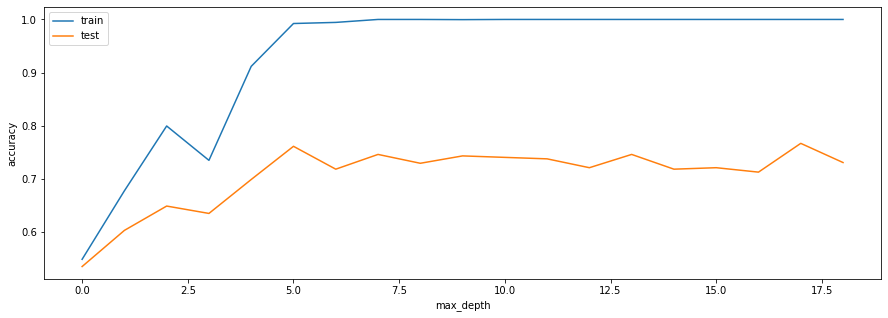

In [30]:
plt.figure(figsize = (15, 5))
plt.plot(train_scores)
plt.plot(test_scores)
plt.legend(['train', 'test'])
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.savefig('./xgboost_result.png')
plt.show()

#### Adapt the selected max_depth

In [136]:
xgb = XGBClassifier(max_depth=8, n_estimators=1000)
xgb.fit(train_scaled, train_target, eval_set = [(test_scaled, test_target)], early_stopping_rounds= 10, eval_metric = 'error')

[0]	validation_0-error:0.435506
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.409154
[2]	validation_0-error:0.402219
[3]	validation_0-error:0.371706
[4]	validation_0-error:0.373093
[5]	validation_0-error:0.367545
[6]	validation_0-error:0.371706
[7]	validation_0-error:0.375867
[8]	validation_0-error:0.370319
[9]	validation_0-error:0.350902
[10]	validation_0-error:0.339806
[11]	validation_0-error:0.349515
[12]	validation_0-error:0.332871
[13]	validation_0-error:0.337032
[14]	validation_0-error:0.332871
[15]	validation_0-error:0.334258
[16]	validation_0-error:0.330097
[17]	validation_0-error:0.323162
[18]	validation_0-error:0.32871
[19]	validation_0-error:0.335645
[20]	validation_0-error:0.337032
[21]	validation_0-error:0.317614
[22]	validation_0-error:0.312067
[23]	validation_0-error:0.305132
[24]	validation_0-error:0.306519
[25]	validation_0-error:0.303745
[26]	validation_0-error:0.295423
[27]	validation_0-error:0.303745
[28]	validation_0-err

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [137]:
print(xgb.score(train_scaled, train_target), xgb.score(test_scaled, test_target))

0.9993055555555556 0.7281553398058253


## Test the model

### Get test data and pre processing

In [154]:
test_arr = np.load('./FordA_test_modified.npy')
test_input = test_arr[:, 1:]
test_target = test_arr[:, 0]
print(test_input.shape, test_target.shape)

(1320, 500) (1320,)


In [155]:
mean = test_input.mean()
std = test_input.std()

test_scaled = (test_input - mean) / std

In [156]:
test_scaled3 = test_scaled.reshape(-1, 500, 1)

In [157]:
cnn_score = cnn.evaluate(test_scaled3, test_target)

42/42 [==============================] - 0s 8ms/step - loss: 0.2995 - accuracy: 0.8788


In [158]:
rnn_score = rnn.evaluate(test_scaled3, test_target)

42/42 [==============================] - 1s 19ms/step - loss: 0.6916 - accuracy: 0.5424


In [159]:
lstm_score = lstm.evaluate(test_scaled3, test_target)

42/42 [==============================] - 1s 27ms/step - loss: 0.6854 - accuracy: 0.5273


In [160]:
gru_score = gru.evaluate(test_scaled3, test_target)

42/42 [==============================] - 1s 23ms/step - loss: 0.6922 - accuracy: 0.5083


In [180]:
lr_predict = lr.predict_proba(test_scaled)

In [181]:
lr_predict.shape

(1320, 2)

In [182]:
xgb_predict = xgb.predict_proba(test_scaled)
print(xgb_predict.shape)

(1320, 2)


In [164]:
cnn_predict = cnn.predict(test_scaled3).flatten()
rnn_predict = rnn.predict(test_scaled3).flatten()
lstm_predict = lstm.predict(test_scaled3).flatten()
gru_predict = gru.predict(test_scaled3).flatten()

In [185]:
# since prob >= 0.5 is class 1, take 2nd prob from ML predicted result
outputs = np.array([cnn_predict, rnn_predict, lstm_predict, gru_predict, lr_predict[:, 1], xgb_predict[:, 1]])
print(outputs.shape)

(6, 1320)


## Visualize the result

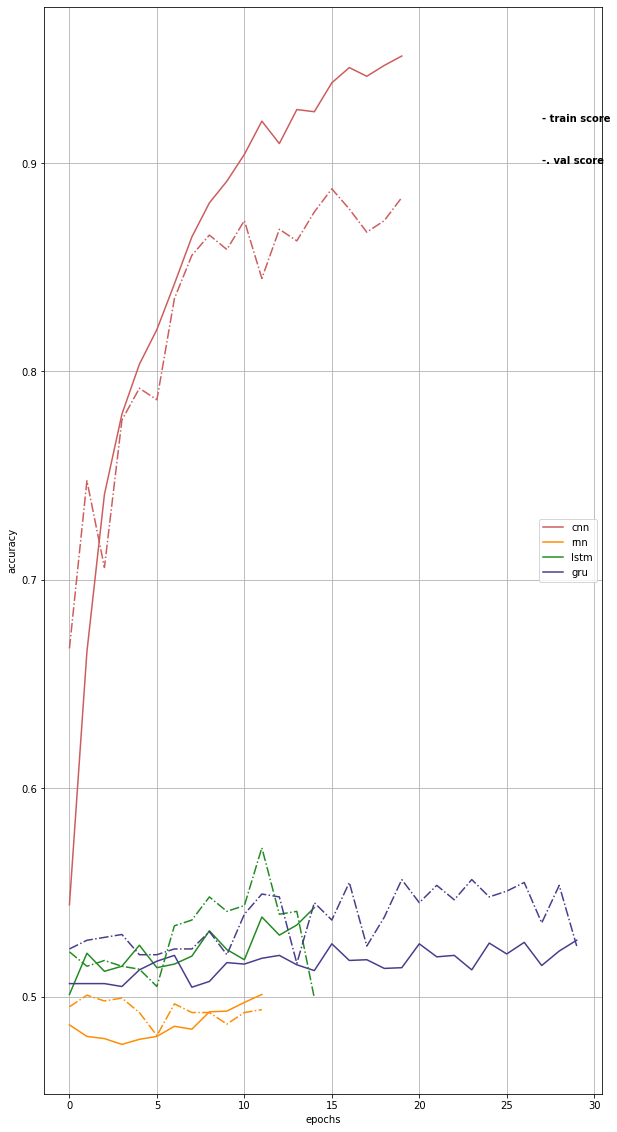

In [166]:
plt.figure(figsize = (10, 20))
color_map = ('indianred', 'darkorange', 'forestgreen', 'darkslateblue')
plt.plot(cnn_history.history['accuracy'], color = color_map[0], label = 'cnn')
plt.plot(rnn_history.history['accuracy'], color = color_map[1], label = 'rnn')
plt.plot(lstm_history.history['accuracy'], color = color_map[2], label = 'lstm')
plt.plot(gru_history.history['accuracy'], color = color_map[3], label = 'gru')
plt.plot(cnn_history.history['val_accuracy'], color = color_map[0], linestyle = "-.")
plt.plot(rnn_history.history['val_accuracy'], color = color_map[1], linestyle = "-.")
plt.plot(lstm_history.history['val_accuracy'], color = color_map[2], linestyle = "-.")
plt.plot(gru_history.history['val_accuracy'], color = color_map[3], linestyle = "-.")
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.text(27, 0.92, '- train score', fontweight = 'bold')
plt.text(27, 0.90, '-. val score', fontweight = 'bold')
plt.legend(loc = 'center right')
plt.savefig('./FordA_result.png')
plt.grid(True)
plt.show()

In [167]:
print('\tCNN \t RNN \t LSTM \t GRU')
print('train:\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f} '.format(statistics.mean(cnn_history.history['accuracy']), statistics.mean(rnn_history.history['accuracy']), statistics.mean(lstm_history.history['accuracy']), statistics.mean(gru_history.history['accuracy'])))
print('val:\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f} '.format(statistics.mean(cnn_history.history['val_accuracy']), statistics.mean(rnn_history.history['val_accuracy']), statistics.mean(lstm_history.history['val_accuracy']), statistics.mean(gru_history.history['val_accuracy'])))

	CNN 	 RNN 	 LSTM 	 GRU
train:	0.857	0.487	0.523	0.516 
val:	0.830	0.493	0.529	0.537 


## Voted Ensemble: Soft voting
- get average probability of models for each data
- if avg prob >= 0.5 -> class 1
- otherwise -> class 0

In [176]:
class SoftEnsemble:
    def __init__(self):
        super().__init__()
    
    # get average probability of models for each data row
    def soft_ensemble(self, outputs):
        average = []
        for i in range(outputs.shape[1]):
            sum = 0
            for j in range(outputs.shape[0]):
                sum += outputs[j][i]
            average.append(sum / outputs.shape[0])
        average = np.array(average)
        return average
        
    # if avg prob >= 0.5, class is 1
    def decision(self, average):
        decision = []
        for i in range(len(average)):
            if(average[i] >= 0.5):
                decision.append(1)
            else:
                decision.append(0)
        
        return decision

    # compare predicted result with real answer
    def scoring(self, prediction, answer):
        score = 0
        for i in range(len(prediction)):
            if(prediction[i] == answer[i]):
                
                score += 1
        return score / len(prediction)

In [186]:
se = SoftEnsemble()
print(outputs.shape)
average = se.soft_ensemble(outputs)
decision = se.decision(average)
print(len(decision))
ensemble_test_score = se.scoring(decision, test_target)
print(ensemble_test_score)

(6, 1320)
1320
0.8651515151515151


In [189]:
# save the result as tsv file
infile = open('FordA_result.tsv', 'w')
infile.write('\tCNN \t RNN \t LSTM \t GRU \t Logistic Regression \t XGBoost \t Soft Voting\n')
infile.write('train:\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\n'.format(statistics.mean(cnn_history.history['accuracy']), statistics.mean(rnn_history.history['accuracy']), statistics.mean(lstm_history.history['accuracy']), statistics.mean(gru_history.history['accuracy']), np.mean(lr_score['train_score']), xgb.score(train_scaled, train_target)))
infile.write('val:\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\n'.format(statistics.mean(cnn_history.history['val_accuracy']), statistics.mean(rnn_history.history['val_accuracy']), statistics.mean(lstm_history.history['val_accuracy']), statistics.mean(gru_history.history['val_accuracy']), np.mean(lr_score['test_score']), xgb.score(test_scaled, test_target)))
infile.write('test:\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t\t\t{:.3f}\n'.format(cnn_score[1], rnn_score[1], lstm_score[1], gru_score[1], ensemble_test_score))

infile.close()